<a href="https://colab.research.google.com/github/dwdb/VAE/blob/master/vae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

!nvidia-smi

Mon Jun 29 05:52:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |    419MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

1 1000 tf.Tensor(142.02975, shape=(), dtype=float32)
true images:


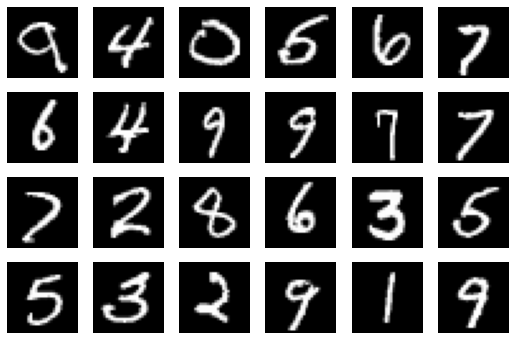

generated images:


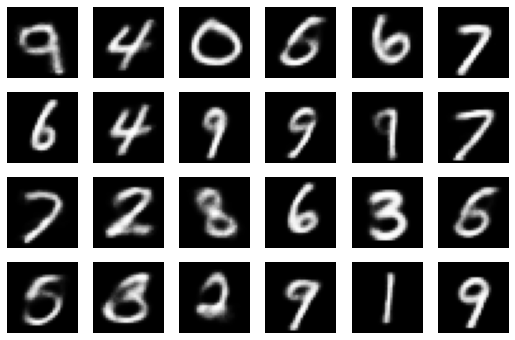


2 2000 tf.Tensor(109.556274, shape=(), dtype=float32)
true images:


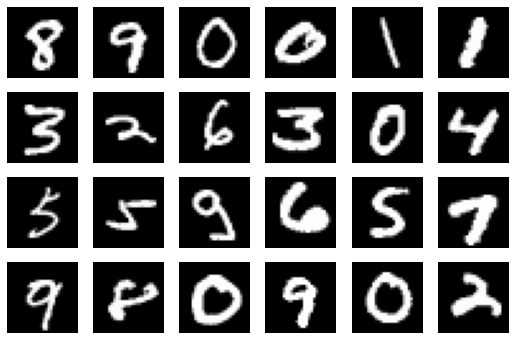

generated images:


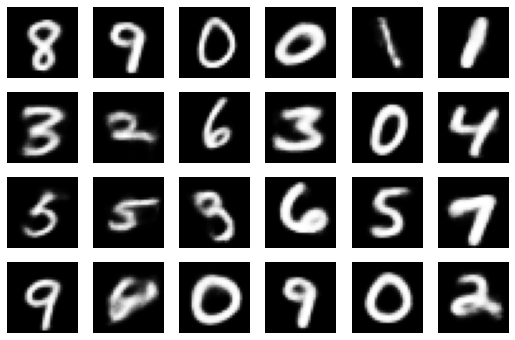


3 3000 tf.Tensor(105.36598, shape=(), dtype=float32)
true images:


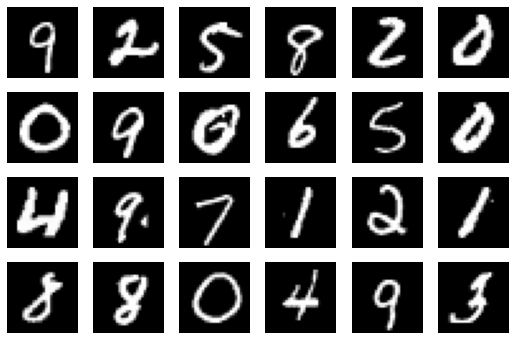

generated images:


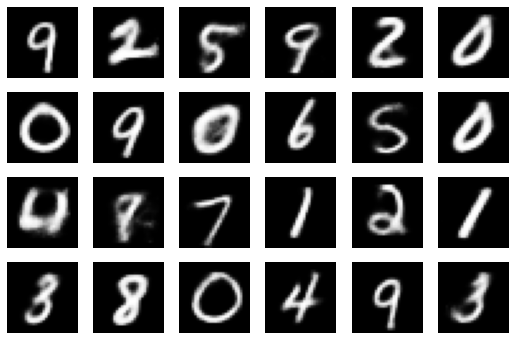


generated images with random vector:


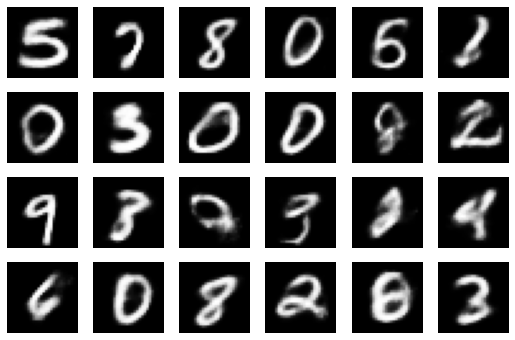


4 4000 tf.Tensor(103.06337, shape=(), dtype=float32)
true images:


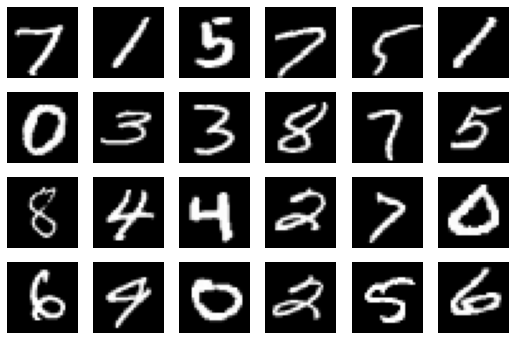

generated images:


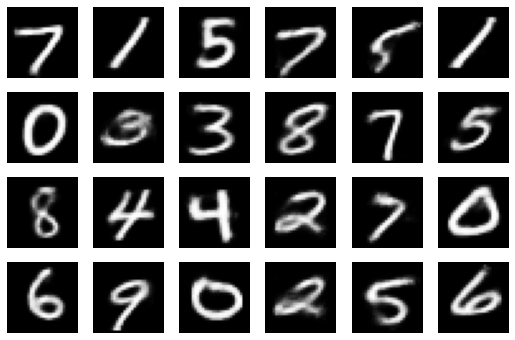


5 5000 tf.Tensor(101.27492, shape=(), dtype=float32)
true images:


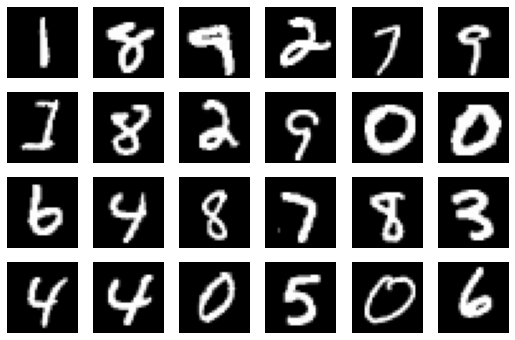

generated images:


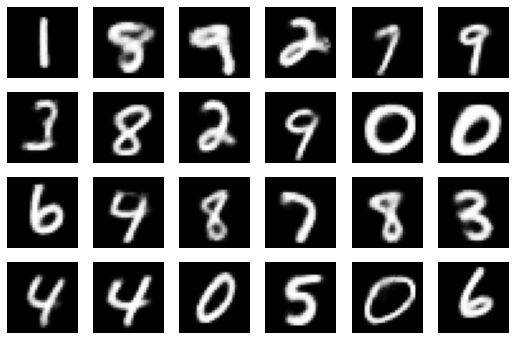


6 6000 tf.Tensor(99.99348, shape=(), dtype=float32)
true images:


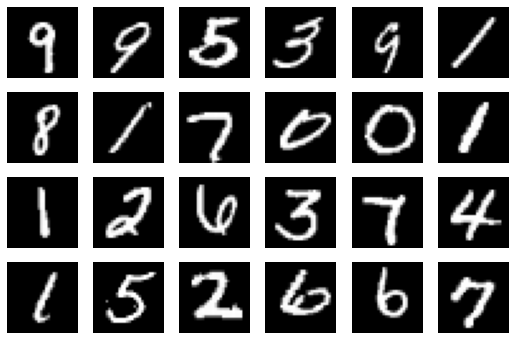

generated images:


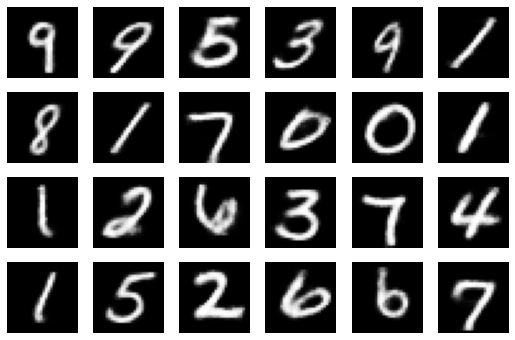


generated images with random vector:


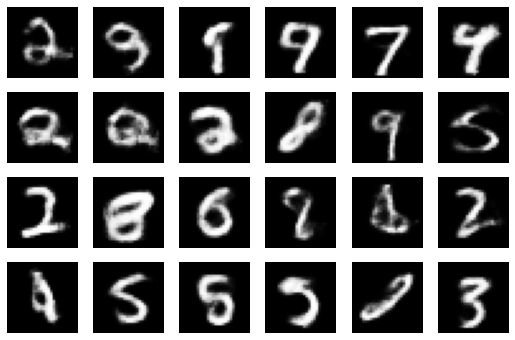


7 7000 tf.Tensor(98.790215, shape=(), dtype=float32)
true images:


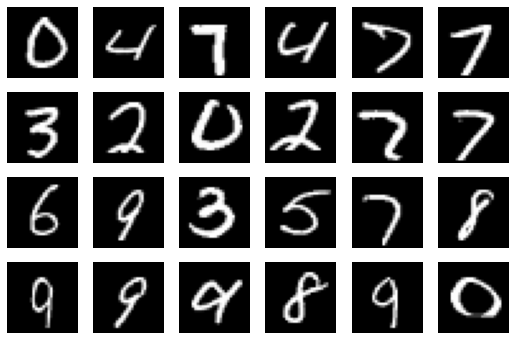

generated images:


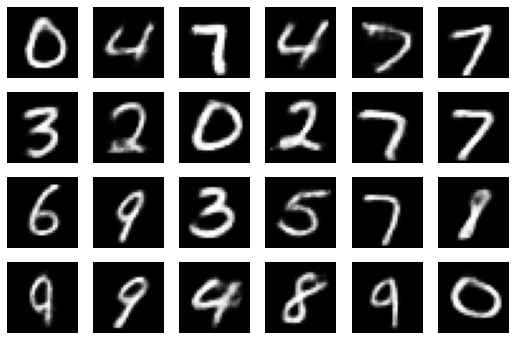


8 8000 tf.Tensor(97.83848, shape=(), dtype=float32)
true images:


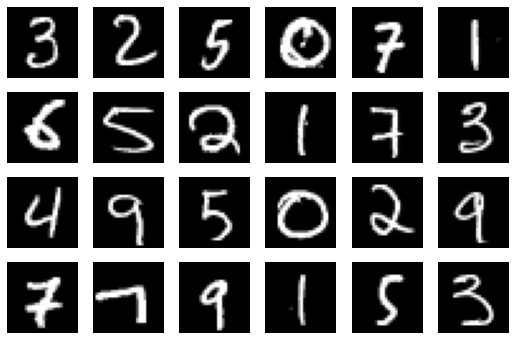

generated images:


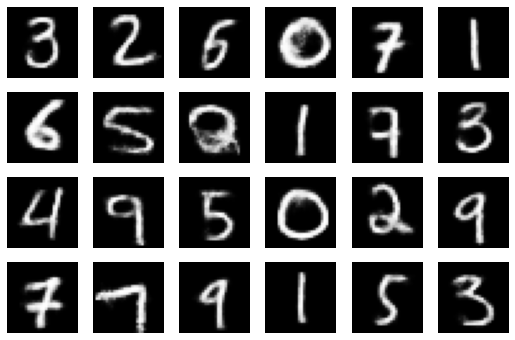


9 9000 tf.Tensor(96.79664, shape=(), dtype=float32)
true images:


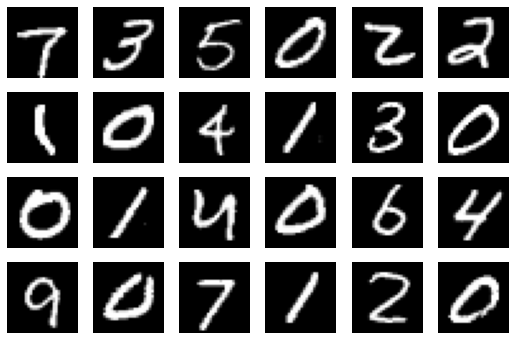

generated images:


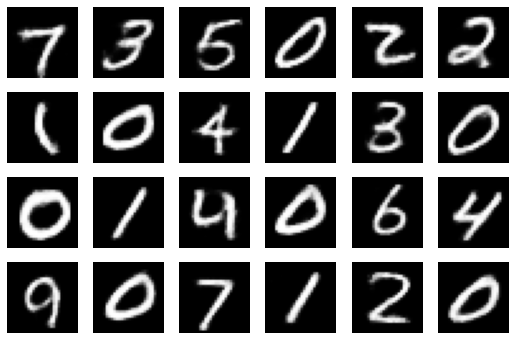


generated images with random vector:


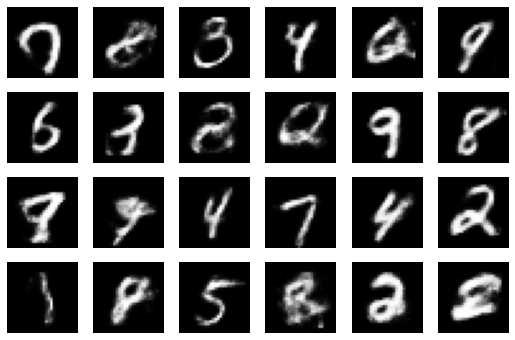


10 10000 tf.Tensor(96.09462, shape=(), dtype=float32)
true images:


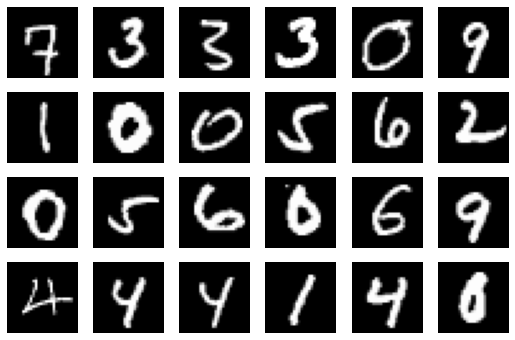

generated images:


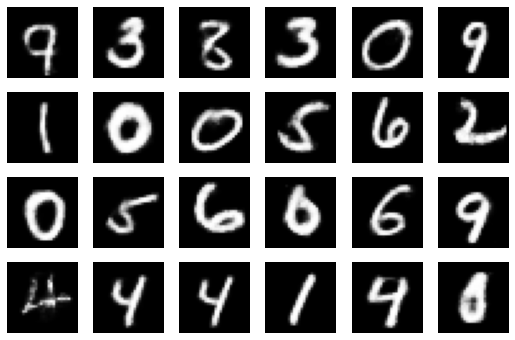


11 11000 tf.Tensor(95.51177, shape=(), dtype=float32)
true images:


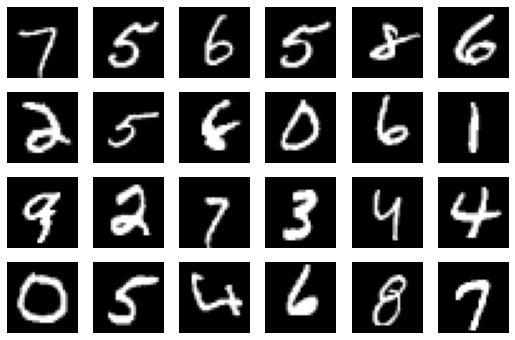

generated images:


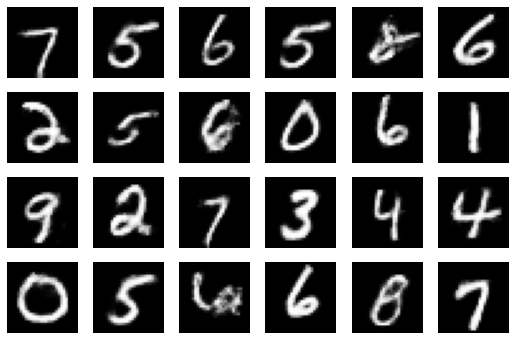


12 12000 tf.Tensor(95.02427, shape=(), dtype=float32)
true images:


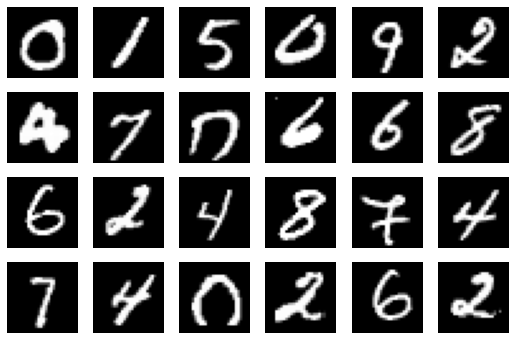

generated images:


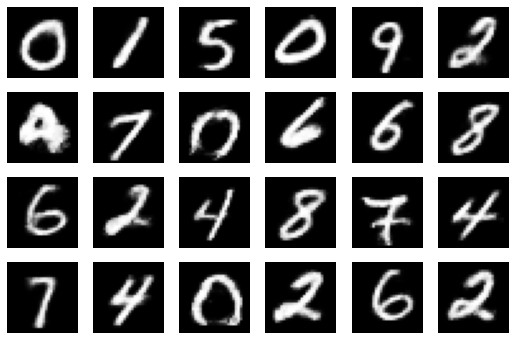


generated images with random vector:


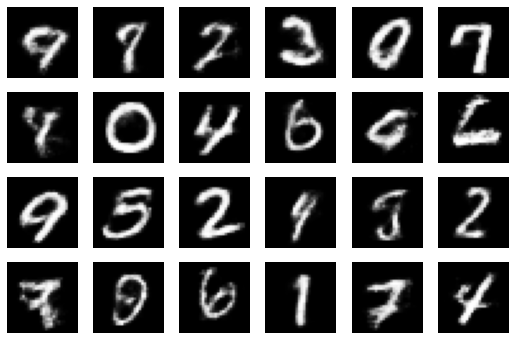


13 13000 tf.Tensor(94.433876, shape=(), dtype=float32)
true images:


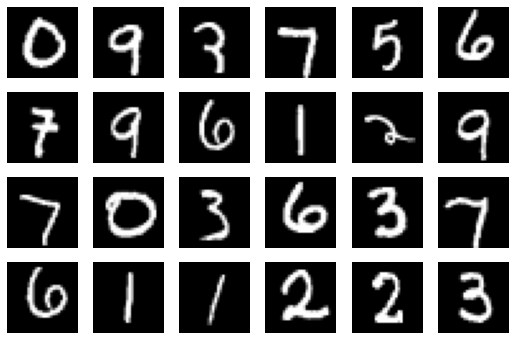

generated images:


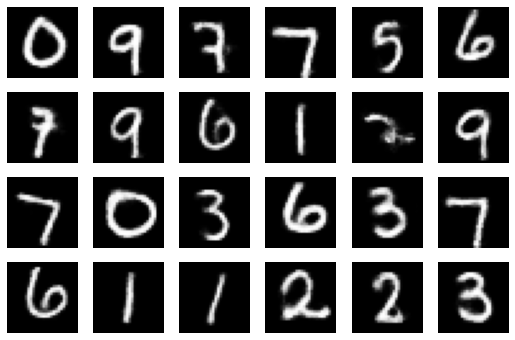


14 14000 tf.Tensor(94.10874, shape=(), dtype=float32)
true images:


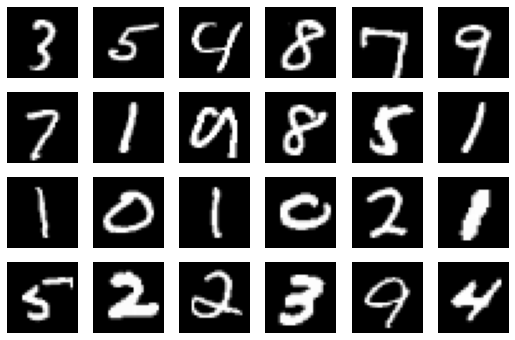

generated images:


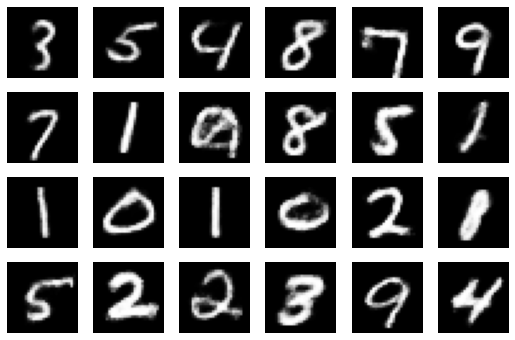


15 15000 tf.Tensor(93.58534, shape=(), dtype=float32)
true images:


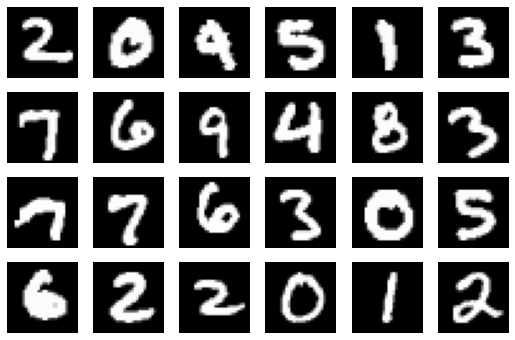

generated images:


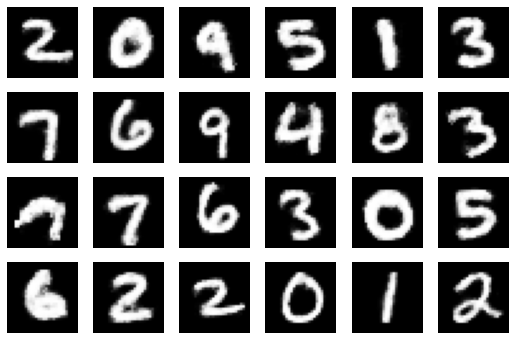


generated images with random vector:


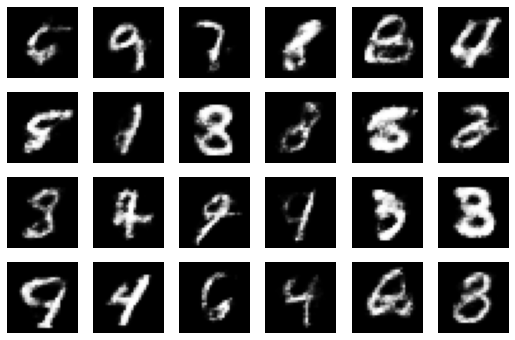


17 16000 tf.Tensor(93.12742, shape=(), dtype=float32)
true images:


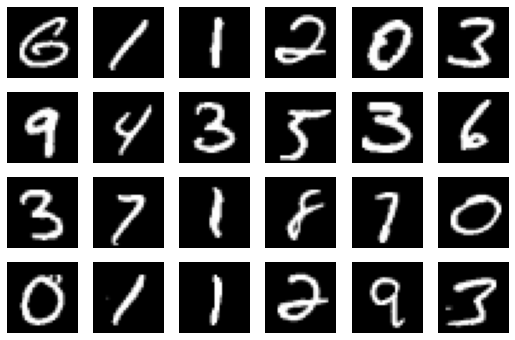

generated images:


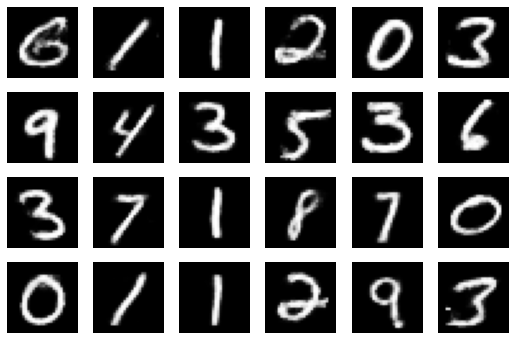


18 17000 tf.Tensor(92.7175, shape=(), dtype=float32)
true images:


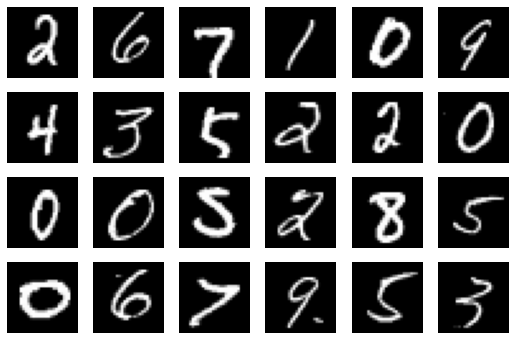

generated images:


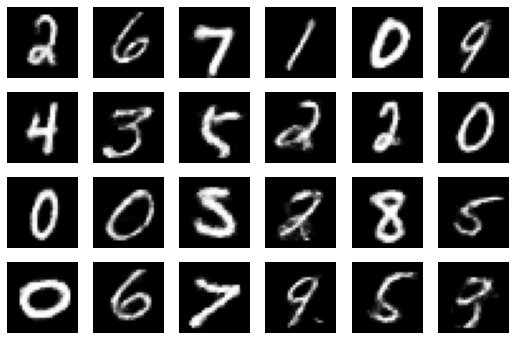


19 18000 tf.Tensor(92.51997, shape=(), dtype=float32)
true images:


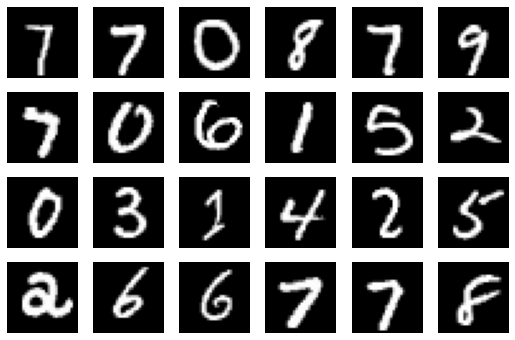

generated images:


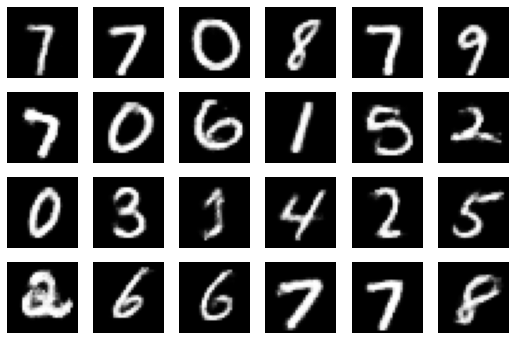


generated images with random vector:


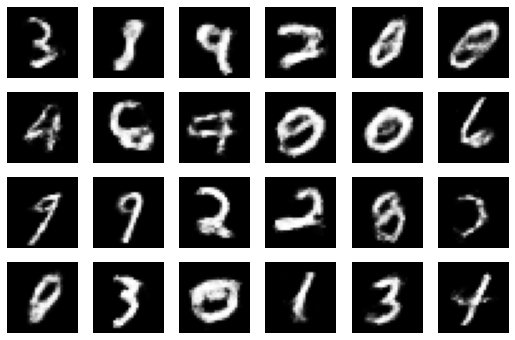

In [ ]:
class VAEModel(tf.keras.Model):
    def __init__(self, img_shape=(28, 28, 1), latent_dim=10):
        super(VAEModel, self).__init__()

        self.img_shape = img_shape
        self.latent_dim = latent_dim

        self.conv_output_shape = None

        self.encoder = self.gaussian_mlp_encoder()
        self.decoder = self.bernoulli_mlp_decoder()

    def gaussian_mlp_encoder(self):
        inputs = tf.keras.Input(shape=self.img_shape)
        # convolution layer
        x = tf.keras.layers.Conv2D(64, 4, 1, padding='same', activation='relu')(inputs)
        x = tf.keras.layers.Conv2D(64, 4, 2, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(32, 4, 1, padding='same', activation='relu')(x)
        self.conv_output_shape = x.shape[1:]
        # output the mean and variance of each example
        x = tf.keras.layers.Flatten()(x)
        mean = tf.keras.layers.Dense(self.latent_dim)(x)
        stddev = tf.keras.layers.Dense(self.latent_dim, 'softplus')(x)
        # encoder model
        model = tf.keras.Model(inputs=inputs, outputs=(mean, stddev))
        return model

    def bernoulli_mlp_decoder(self):
        inputs = tf.keras.Input(shape=(self.latent_dim, ))
        y = tf.keras.layers.Dense(np.prod(self.conv_output_shape), 'relu')(inputs)
        y = tf.reshape(y, (-1, *self.conv_output_shape))
        # reverse convolution layer
        y = tf.keras.layers.Conv2DTranspose(32, 4, 1, padding='same', activation='relu')(y)
        y = tf.keras.layers.Conv2DTranspose(64, 4, 2, padding='same', activation='relu')(y)
        y = tf.keras.layers.Conv2DTranspose(64, 4, 1, padding='same', activation='relu')(y)
        # output image generated by the decoder
        y = tf.keras.layers.Flatten()(y)
        y = tf.keras.layers.Dense(np.prod(self.img_shape), 'sigmoid')(y)
        y = tf.reshape(y, shape=(-1, *self.img_shape))
        # decoder model
        model = tf.keras.Model(inputs=inputs, outputs=y)
        return model

    def call(self, x, training=False):
        mu, sigma = self.encoder(x)
        z = mu + sigma * tf.random.normal(tf.shape(mu), dtype=tf.float32)
        y = self.decoder(z)
        return y, mu, sigma


class VAE(object):
    def __init__(self):
        self.model = VAEModel()
        self.optimizer = tf.keras.optimizers.Adam(0.001)
        self.metric_loss = tf.keras.metrics.Mean('loss')

        self.global_step = tf.Variable(0, dtype=tf.int32, name='global_step', trainable=False)
    
    def loss(self, x, y, mu, sigma):
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, shape=(batch_size, -1))
        y = tf.reshape(y, shape=(batch_size, -1))
        y = tf.clip_by_value(y, 1e-6, 1 - 1e-6)
        marginal_likelihood = x * tf.math.log(y) + (1. - x) * tf.math.log(1. - y)
        marginal_likelihood = tf.reduce_mean(tf.reduce_sum(marginal_likelihood, axis=1))
        kl_divergence = 0.5 * (mu**2 + sigma**2 - tf.math.log(1e-8 + sigma**2) - 1.)
        kl_divergence = tf.reduce_mean(tf.reduce_sum(kl_divergence, axis=1))
        loss = kl_divergence - marginal_likelihood
        return loss, kl_divergence, - marginal_likelihood

    def train(self, dataset, epochs, batch_size):
        step = 0
        for epoch in range(epochs):
            for i in range(0, len(dataset), batch_size):
                x = dataset[i:i+batch_size]
                loss, y, kl_divergence, marginal_likelihood = self.train_step(x)
                step += 1

                if step % 1000 == 0:
                    print(epoch, step, self.metric_loss.result())
                    self.metric_loss.reset_states()
                    print('true images:')
                    self.show_images(np.squeeze(x))
                    print('generated images:')
                    self.show_images(np.squeeze(y))
                    print()

                if self.global_step % 3000 == 0:
                    print('generated images with random vector:')
                    z = tf.random.normal((24, self.model.latent_dim))
                    zy = self.model.decoder(z)
                    self.show_images(np.squeeze(zy))
                    print()

    @tf.function(input_signature=[tf.TensorSpec((None, 28, 28, 1))])
    def train_step(self, x):
        with tf.GradientTape() as tape:
            y, z_mean, z_sigma = self.model(x, training=True)
            loss, kl_divergence, marginal_likelihood = self.loss(x, y, z_mean, z_sigma)
        
        grads = tape.gradient(loss, self.model.trainable_variables)
        grads = [tf.clip_by_value(grad, -5., 5.) for grad in grads]
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        self.metric_loss(loss)
        self.global_step.assign_add(1)
        return loss, y, kl_divergence, marginal_likelihood

    @staticmethod
    def show_images(images):
        images = images[:24]
        plt.figure(figsize=(9, 6))
        for i, image in enumerate(images, 1):
            plt.subplot(4, 6, i)
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.show()


(x_train, _), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=-1)

vae = VAE()
vae.train(x_train, epochs=20, batch_size=64)